In [0]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

np.random.seed(2)

from sklearn.model_selection import train_test_split

import keras
from keras.utils.np_utils import to_categorical
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPool2D, Activation
from keras.preprocessing.image import ImageDataGenerator

In [0]:
#데이터를 불러옵니다.
(X_train, Y_train), (X_test, Y_test) = keras.datasets.mnist.load_data()

In [0]:
import cv2

In [11]:
X_train.shape

(60000, 28, 28)

In [12]:
#데이터를 확인합니다(colab의 경우 cv2.imshow가 실행이 안되어 plt.imshow를 사용하시면 됩니다.)
cv2.imshow(X_train[0],cv2.IMREAD_COLOR)

DisabledFunctionError: ignored

In [0]:
#위에서 shape을 확인한 결과 (60000,28,28)로 각 이미지는 2차원 데이터입니다.
#CNN은 가로x세로x채널의 3차원의 이미지를 사용하므로 input이미지를 4차원 데이터로 바꾸어줍니다(이미지=3차원, 그 이미지들 묶으니까 차원 하나 더 추가)
X_train = X_train.reshape(X_train.shape[0],28,28,1)
X_test = X_test.reshape(X_test.shape[0],28,28,1)

#정답의 경우 categorical이기에 해당 변수로 변환합니다.
Y_train = keras.utils.to_categorical(Y_train, 10)
Y_test = keras.utils.to_categorical(Y_test, 10)

#0~255사이의 값을 갖는 픽셀들을 0~1의 값을 가지도록 변환시킵니다.
X_train = X_train.astype('float32') / 255.
X_test = X_test.astype('float32') / 255.

random_seed = 2
#train set을 다시 train과 validation으로 나누어 줍니다.
X_train, X_val, Y_train, Y_val = train_test_split(X_train, Y_train, test_size=0.1, random_state = random_seed)

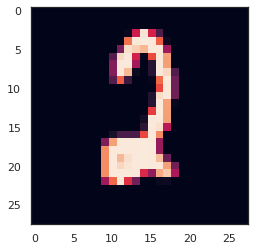

In [15]:
plt.imshow(X_train[1][:,:,0])

In [18]:
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, BatchNormalization
#저는 keras로 진행합니다.
def build_model():
    #이 모델이 sequential한 모델임을 선언합니다(그냥 쭉 직선, 발표 ppt에 googleNet의 경우가 예외)
    model = Sequential()
    #Convolution Layer를 추가합니다. 이 Layer에는 산출하는 Activation map의 갯수, 사용하는 filter의 크기, padding, stride를 설정하며
    #추가적으로 Activation function, weight initializer를 추가할 수 있습니다.
    model.add(Conv2D(filters=16, kernel_size=(1,1),input_shape=(28, 28, 1)))
    model.add(Conv2D(filters=16, kernel_size=(1,1)))
    model.add(Conv2D(filters=16, kernel_size=(1,1)))
    #pooling layer를 추가합니다.
    model.add(MaxPooling2D(pool_size=(2,2)))
    #feature extraction을 마쳤으므로 이를 MLP에 넣기위해 데이터를 flatten시킵니다. 즉 image의 shape를 3차원 -> 1차원으로 변경합니다.
    model.add(Flatten())
    #이후는 기존에 진행했던 MLP구조와 같습니다.
    model.add(Dense(128, activation='relu',kernel_initializer='he_normal'))
    #예측값이 1~10의 10개이므로 output을 10개로 설정합니다. 이를 softmax를 거치게합니다.
    model.add(Dense(10, activation='softmax'))
    #optimizer로 adam을 사용하고 사용하는 loss값은 cross entropy입니다. 학습하며 accuracy도 같이 봅니다만 이는 학습에 영향을 미치지 않습니다.
    model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
    return model

model = build_model()

In [0]:
#이미지 학습에서 중요한 요소 중 하나는 augumentation입니다. 이미지를 좌,우로 반전시키거나, 회전하거나, 확대시킵니다.
#즉 배치마다 데이터의 모양이 달라집니다. 그리고 데이터를 더 많이 넣을 수도 있습니다.
#이 내용은 세션 내용에는 없지만 너무 중요한 부분이라 넣었습니다.
datagen = ImageDataGenerator(
        featurewise_center=False,  # set input mean to 0 over the dataset
        samplewise_center=False,  # set each sample mean to 0
        featurewise_std_normalization=False,  # divide inputs by std of the dataset
        samplewise_std_normalization=False,  # divide each input by its std
        zca_whitening=False,  # apply ZCA whitening
        rotation_range=10,  # randomly rotate images in the range (degrees, 0 to 180)
        zoom_range = 0.1, # Randomly zoom image 
        width_shift_range=0.1,  # randomly shift images horizontally (fraction of total width)
        height_shift_range=0.1,  # randomly shift images vertically (fraction of total height)
        horizontal_flip=False,  # randomly flip images
        vertical_flip=False)  # randomly flip images


datagen.fit(X_train)

In [21]:
#Image generator를 사용하며 학습시키는 경우 model.fit이 아니라 model.fit_generator를 사용합니다.
#아래의 결과는 위의 예제코드의 결과가 아닙니다!!!
results = model.fit_generator(datagen.flow(X_train,Y_train,batch_size=64), 
                    epochs=30,validation_data=(X_val, Y_val), steps_per_epoch=X_train.shape[0]//64)

Epoch 1/30
843/843 [==============================] - 19s 22ms/step - loss: 0.6511 - acc: 0.8014 - val_loss: 0.1023 - val_acc: 0.9728
Epoch 2/30
843/843 [==============================] - 18s 22ms/step - loss: 0.2092 - acc: 0.9388 - val_loss: 0.0554 - val_acc: 0.9830
Epoch 3/30
843/843 [==============================] - 19s 22ms/step - loss: 0.1538 - acc: 0.9548 - val_loss: 0.0642 - val_acc: 0.9787
Epoch 4/30
843/843 [==============================] - 18s 22ms/step - loss: 0.1206 - acc: 0.9644 - val_loss: 0.0361 - val_acc: 0.9887
Epoch 5/30
843/843 [==============================] - 19s 22ms/step - loss: 0.1056 - acc: 0.9694 - val_loss: 0.0446 - val_acc: 0.9867
Epoch 6/30
843/843 [==============================] - 18s 22ms/step - loss: 0.0953 - acc: 0.9722 - val_loss: 0.0297 - val_acc: 0.9907
Epoch 7/30
843/843 [==============================] - 19s 22ms/step - loss: 0.0847 - acc: 0.9755 - val_loss: 0.0244 - val_acc: 0.9932
Epoch 8/30
843/843 [==============================] - 18s 22ms

In [24]:
#학습시킨 모델을 test data에 적용하여 일반화가 성공적으로 되었는지 확인합니다.
#이 test accuracay가 0.99 이상이 되어야 합니다.
test_loss, test_accuracy = \
  model.evaluate(X_test, Y_test, batch_size=64)
print('Test loss: %.4f accuracy: %.4f' % (test_loss, test_accuracy))

10000/10000 [==============================] - 0s 50us/step
Test loss: 0.0131 accuracy: 0.9949
